# BERT Baseline with All Streamers Data

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
import itertools
from tqdm.notebook import tqdm
import pickle
tqdm.pandas()

# ORIGIN_DATA = pd.read_pickle('../../data/new_txn.pkl')
# BERT = np.load('../../data/jambo_iname2embedding.npy', allow_pickle=True)[None][0]

In [24]:
# 測試少量資料
ORIGIN_DATA = pd.read_pickle('../../data/new_txn.pkl')
DATA = ORIGIN_DATA.reset_index(drop=True)

## Preprocessing & Storage

In [25]:
%%time
'''
Make Stream Indexer
'''
DATA['stream'] = DATA['user_id'].astype(str) + DATA['場次'].astype(str)

# Set stream_id in time order
sorted_streams = DATA.sort_values(by=['下單日期'])['stream'].reset_index(drop=True).unique()
stream_dict = { x: i for i, x in enumerate(sorted_streams) }

DATA['stream'] = DATA['stream'].map(stream_dict)

CPU times: user 7.9 s, sys: 1.13 s, total: 9.03 s
Wall time: 9.02 s


In [26]:
%%time
'''
THRESHOLDS
1. Users bought threshold: could be 9/15/25/1(consider all)
2. Stream buyer threshold: could be 2/25/73/209
   -> 避免 Feature 即為正確答案
'''
buy_threshold = 9
stream_threshold = 1

user_count = DATA.groupby(['asid']).count()
uid = user_count['下單日期'].loc[user_count['下單日期'] > buy_threshold].index
DATA = DATA.loc[DATA['asid'].isin(uid)]

data_groupby_stream = DATA.groupby(['stream'])
g_s_count = data_groupby_stream.count()
available_streams = g_s_count.loc[g_s_count['訂單編號'] > stream_threshold].index
DATA = DATA.loc[DATA['stream'].isin(available_streams)]

CPU times: user 15.8 s, sys: 816 ms, total: 16.6 s
Wall time: 16.6 s


In [27]:
%%time
'''
period & item_id
'''
DATA['period'] = DATA['下單日期'].astype(str).apply(lambda x: x[:7])
DATA.rename(columns = {'商品id': 'item_id'}, inplace=True)

CPU times: user 32.7 s, sys: 68 ms, total: 32.7 s
Wall time: 32.6 s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
%%time
'''
One Hot Encoding
* 處理 shipment, payment
* 要先做 label encoding 才能做 one hot encoding
'''
le = LabelEncoder()

DATA['shipment'] = le.fit_transform(DATA['運送方式'])
DATA['payment'] = le.fit_transform(DATA['付款方式'])
DATA['streamer_id'] = le.fit_transform(DATA['user_id'])
DATA = pd.get_dummies(DATA,
                      prefix=['shipment', 'payment', 'streamer'],
                      columns=['shipment', 'payment', 'streamer_id'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

CPU times: user 9.27 s, sys: 1.04 s, total: 10.3 s
Wall time: 10.3 s


In [29]:
%%time
'''
USER Features 
Generate USER_STREAM_CONTEXT
'''
data_groupby_user_stream = DATA.groupby(['asid', 'stream'])


# Get group by sum
USER_STREAM_CONTEXT = data_groupby_user_stream.sum()
USER_STREAM_CONTEXT = USER_STREAM_CONTEXT[['shipment_0', 'shipment_1', 'shipment_2', 'shipment_3', 
                                           'shipment_4', 'shipment_5', 'shipment_6', 'payment_0', 
                                           'payment_1', 'payment_2', 'payment_3', 'payment_4', 'payment_5',
                                           'payment_6', 'payment_7', 'payment_8', 'streamer_0', 'streamer_1',
                                           'streamer_2', 'streamer_3', 'streamer_4', 'streamer_5', 
                                           'streamer_6', 'streamer_7', 'streamer_8']]

# Get group by count & mean
u_s_count = data_groupby_user_stream.count()
u_s_avg = data_groupby_user_stream.mean()

# Assign seleted values to USER_STREAM_CONTEXT
USER_STREAM_CONTEXT[['channel_name', 'user_id', 'item_id', '訂單編號', '專屬折扣']] = u_s_count[['channel_name', 'user_id', 'item_id', '訂單編號', '專屬折扣']]
USER_STREAM_CONTEXT[['運費', '總金額', '數量', '單價']] = u_s_avg[['運費', '總金額', '數量', '單價']]

# Rename columns
USER_STREAM_CONTEXT.rename(columns={'user_id': 'streamer_id',
                                    'channel_name': 'channel_cnt',
                                    '訂單編號': 'order_cnt',
                                    'item_id': 'item_var_cnt',
                                    '運費': 'shipment_fee',
                                    '專屬折扣': 'discount',
                                    '總金額': 'total_price',
                                    '單價': 'avg_item_price',
                                    '數量': 'avg_item_cnt'
                                   },
                           inplace=True)

CPU times: user 12.3 s, sys: 2.12 s, total: 14.4 s
Wall time: 14.4 s


In [8]:
%%time
'''
USER_STREAM_MDB: user bought history average embedding (by stream) through items.unique.index
* BERT_INDEX: [item_name] -> item_idx
* item_name_embedding: [item_idx] -> item_embedding
* user_stream_buy_list: (buyer, stream) -> [items]
'''
# Append item embeddings according to items list's order & convert to np array
item_names = DATA['item_name'].unique().tolist()
ITEM_EMB_BY_IDX = []
for iname in tqdm(item_names):
  ITEM_EMB_BY_IDX.append(BERT[iname])
ITEM_EMB_BY_IDX = np.array(ITEM_EMB_BY_IDX)

# Map item name to item index
BERT_INDEX = {name:i for i, name in enumerate(item_names)}

# Item names grouped by asid & stream
user_stream_buy_list = DATA.groupby(['asid', 'stream'])['item_name'].apply(list)

  0%|          | 0/162189 [00:00<?, ?it/s]

CPU times: user 48.4 s, sys: 207 ms, total: 48.6 s
Wall time: 48.6 s


In [9]:
'''
Calculate user cumulated stream embedding
* user_stream_order_dict: { User: [stream list in order] }
* buy list: [asid, streams]
* 需求：可以選擇要「給予權重」或「直接平均」
'''
user_stream_order = DATA[['asid', 'stream']].groupby(['asid'])['stream'].apply(set)
USER_LIST = DATA['asid'].unique().tolist()
# test asid: ['1000057940522534']
# test streams: {3397, 3415, 3815, 3865, 4365, 4478, 4563, 5028}

# AVG
FINAL_EMB = {}
for asid in tqdm(USER_LIST):
  # find all the stream user attended and sort them in time order
  streamlist = list(user_stream_order[asid])
  streamlist.sort()
  # find items bought in each stream
  buylist = [user_stream_buy_list[asid, stream] for stream in streamlist]
  # cumulated items bought in each stream
  cumulative_buylist = [sum(buylist[:i], []) for i in range(1, len(buylist) + 1)]
  # map { stream: cumulate_items } to a dictionary
  cumulative_dict = dict(zip(streamlist, cumulative_buylist))
  # calculate average embedding and put them into FINAL_EMB
  # FOR EACH STREAM
  for k in cumulative_dict.keys():
    # get all items' name from stream
    i_list = cumulative_dict[k]
    # get items' BERT_INDEX for retrived items
    all_buy_item_index = [BERT_INDEX[item] for item in i_list]
    # get their embeddings and calculate mean
    user_emb = ITEM_EMB_BY_IDX[all_buy_item_index].mean(axis=0)
    # put them into the FINAL_EMB as previous set format
    FINAL_EMB[(asid, k)] = user_emb

  0%|          | 0/79207 [00:00<?, ?it/s]

In [10]:
%%time
# store 
with open('cumulative_item_emb.pkl', 'wb') as handle:
    pickle.dump(FINAL_EMB, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load
with open('cumulative_item_emb.pkl', 'rb') as handle:
    b = pickle.load(handle)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [10]:
%%time
'''
ITEM Features
1. Attach item embeddings to DATA
2. Reset ITEM_DF's index
'''
LB_BERT = [f'bert_{x}' for x in range(768)] # constant

# Generate ITEM_DF for DATA
ITEM_FEAT = pd.DataFrame.from_dict(BERT, orient='index').astype('float32') # decrease processing time

CPU times: user 51.9 s, sys: 1.43 s, total: 53.3 s
Wall time: 53.3 s


In [9]:
'''
ITEM_STREAM_DICT: 直播 id 對應到的商品列表
REAL_BOUGHT_DF: 計算 reward 用
LAST_BOUGHT_STREAM: 作為 game_over
'''
# Constant: all stream list
STREAM_LIST = DATA.stream.unique()

# [Reward]
REAL_BOUGHT_DF = DATA.loc[:, ['asid', 'stream', 'item_id']]

# [Action]
LAST_BOUGHT_STREAM = USER_STREAM_CONTEXT.reset_index().groupby('asid', as_index=False).last().loc[:, ['asid', 'stream']].set_index('asid')

In [10]:
%%time
'''
STREAM Features:
* STREAM_FEAT: avg_price, avg_sum, count order #
* STREAM_ITEM_EMB: [stream] -> avg item embedding
'''
data_gb_stream = DATA.groupby(['stream'])
STREAM_FEAT = data_gb_stream.mean()[['單價', '總金額']]
STREAM_FEAT[['count']] = data_gb_stream.count()[['item_name']]
STREAM_FEAT.rename(columns={'單價':'avg_price', '總金額':'avg_sum'}, inplace=True)

# Item names grouped by stream
stream_item_list = data_gb_stream['item_name'].apply(list)

STREAM_ITEM_EMB = {}
for stream in tqdm(stream_item_list.index):
  # Find each stream's items
  item_list = stream_item_list[stream]
  # Find these items' indeces
  all_stream_item_index = [BERT_INDEX[item] for item in item_list]
  # Use the indeces found above to locate BERT embeddings & calculate mean
  stream_emb = ITEM_EMB_BY_IDX[all_stream_item_index].mean(axis=0)
  # Put result into dict
  STREAM_ITEM_EMB[stream] = stream_emb

  0%|          | 0/7701 [00:00<?, ?it/s]

CPU times: user 12.7 s, sys: 2.18 s, total: 14.8 s
Wall time: 14.8 s


In [29]:
'''
Stream item list
stream: item_id_from_uniq
'''
STREAM_ITEM_LIST = {}
for stream in tqdm(stream_item_list.index):
  # Find each stream's items
  item_list = stream_item_list[stream]
  # Find these items' indeces
  all_stream_item_index = [BERT_INDEX[item] for item in item_list]
  # Put result into dict
  STREAM_ITEM_LIST[stream] = all_stream_item_index

with open('stream_item_dict.pkl', 'wb') as handle:
    pickle.dump(STREAM_ITEM_LIST, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/7701 [00:00<?, ?it/s]

In [130]:
STREAM_ITEM_DICT = pd.read_pickle('stream_item_dict.pkl')
for x in STREAM_ITEM_DICT.values():
  if len(x)==111549:
    print(len(x))
    print(len(set(x)))

for k, v in STREAM_ITEM_DICT.items():
  STREAM_ITEM_DICT[k] = list(set(v))

a=[len(x) for x in STREAM_ITEM_DICT.values()]
max(a)

111549
4902


14096

In [131]:
with open('stream_item_dict.pkl', 'wb') as handle:
    pickle.dump(STREAM_ITEM_DICT, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
%%time
# store 
with open('stream_emb.pkl', 'wb') as handle:
    pickle.dump(STREAM_ITEM_EMB, handle, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 35.8 ms, sys: 36 ms, total: 71.7 ms
Wall time: 70.7 ms


In [18]:
USER_STREAM_CONTEXT.to_pickle('user_stream_context.pkl')
STREAM_FEAT.to_pickle('stream_feat.pkl')

In [21]:
np.save('item_emb_by_idx.npy', ITEM_EMB_BY_IDX, allow_pickle=True)

In [ ]:
'''
Data to use(exported)
1. cumulative_item_emb
2. stream_item_emb
3. user_stream_context
4. stream_feat
5. item_emb
6. stream_item_list
'''

In [9]:
CML_ITEM_EMB = pd.read_pickle('cumulative_item_emb.pkl')
USER_STREAM_CONTEXT = pd.read_pickle('user_stream_context.pkl')

In [10]:
%%time
bert_emb = list(map(lambda x: CML_ITEM_EMB[x], USER_STREAM_CONTEXT.index.tolist()))

CPU times: user 1.06 s, sys: 6.26 ms, total: 1.06 s
Wall time: 1.06 s


In [11]:
%%time
emb_dict = {key: emb for key, emb in zip(USER_STREAM_CONTEXT.index, bert_emb)}

CPU times: user 408 ms, sys: 15.8 ms, total: 424 ms
Wall time: 422 ms


In [12]:
pd.Series(emb_dict[('1000057940522534', 3397)])

0      0.439118
1      0.324274
2     -0.210958
3      0.009634
4     -0.085988
         ...   
763    0.463184
764   -0.119197
765   -0.523377
766    0.051746
767    0.031374
Length: 768, dtype: float64

In [13]:
%%time
embseries_dict = {}
for key, item in tqdm(emb_dict.items()):
  embseries_dict[key] = pd.Series(item)
len(embseries_dict) == len(emb_dict)

  0%|          | 0/1397141 [00:00<?, ?it/s]

CPU times: user 1min 38s, sys: 1.07 s, total: 1min 39s
Wall time: 1min 39s


True

In [14]:
def apply_emb(row):
  return embseries_dict[row.name]

In [15]:
%%time
tqdm.pandas()

US_CONTEXT_EMB = USER_STREAM_CONTEXT.progress_apply(lambda x: apply_emb(x), axis=1)

  0%|          | 0/1397141 [00:00<?, ?it/s]

CPU times: user 2min 18s, sys: 5.91 s, total: 2min 23s
Wall time: 2min 23s


In [51]:
FINAL_USER_REPS = USER_STREAM_CONTEXT.merge(pca_result_df, left_index=True, right_index=True).progress_apply(lambda x: x)

  0%|          | 0/106 [00:00<?, ?it/s]

In [52]:
FINAL_USER_REPS

shipment_0  shipment_1  shipment_2  \
asid                              stream                                       
1000057940522534                  3397           0.0         0.0         0.0   
                                  3415           0.0         0.0         0.0   
                                  3815           0.0         0.0         0.0   
                                  3865           0.0         0.0         0.0   
                                  4365           0.0         0.0         0.0   
...                                              ...         ...         ...   
Uff4d074f674ad9495764995e51d905ee 2513           0.0         0.0         0.0   
Uffb50137571903b41efcbb49829729a7 421            0.0         0.0         0.0   
                                  452            0.0         0.0         0.0   
                                  798            0.0         0.0         0.0   
                                  923            0.0         0.0         0.0   

                                          shipment_3  shipment_4  shipment_5  \
asid                              stream                                       
1000057940522534                  3397           5.0         0.0         0.0   
                                  3415           3.0         0.0         0.0   
                                  3815           2.0         0.0         0.0   
                                  3865           5.0         0.0         0.0   
                                  4365           3.0         0.0         0.0   
...                                              ...         ...         ...   
Uff4d074f674ad9495764995e51d905ee 2513           3.0         0.0         0.0   
Uffb50137571903b41efcbb49829729a7 421            2.0         0.0         0.0   
                                  452            1.0         0.0         0.0   
                                  798            3.0         0.0         0.0   
                                  923            4.0         0.0         0.0   

                                          shipment_6  payment_0  payment_1  \
asid                              stream                                     
1000057940522534                  3397           0.0        0.0        0.0   
                                  3415           0.0        0.0        0.0   
                                  3815           0.0        0.0        0.0   
                                  3865           0.0        0.0        0.0   
                                  4365           0.0        0.0        0.0   
...                                              ...        ...        ...   
Uff4d074f674ad9495764995e51d905ee 2513           0.0        0.0        0.0   
Uffb50137571903b41efcbb49829729a7 421            0.0        0.0        0.0   
                                  452            0.0        0.0        0.0   
                                  798            0.0        0.0        0.0   
                                  923            0.0        0.0        0.0   

                                          payment_2  ...        62        63  \
asid                              stream             ...                       
1000057940522534                  3397          0.0  ... -0.226923 -0.023793   
                                  3415          0.0  ... -0.188778 -0.018168   
                                  3815          0.0  ... -0.148792 -0.058619   
                                  3865          0.0  ... -0.078685 -0.025832   
                                  4365          0.0  ... -0.042089 -0.023229   
...                                             ...  ...       ...       ...   
Uff4d074f674ad9495764995e51d905ee 2513          0.0  ... -0.109353  0.038188   
Uffb50137571903b41efcbb49829729a7 421           0.0  ... -0.195958  0.205667   
                                  452           0.0  ... -0.219794  0.064392   
                                  798           0.0  ... -0.07598

In [53]:
FINAL_USER_REPS.to_pickle('final_user_reps.pkl')

In [57]:
STREAM_EMB = pd.read_pickle('stream_emb.pkl')
STREAM_FEAT = pd.read_pickle('stream_feat.pkl')

In [58]:
STREAM_FEAT.head()

,avg_price,avg_sum,count
stream,,,
0,983.406250,1126.656250,64
1,1318.228769,1340.232236,577
2,1020.481748,1035.088377,4164
3,1026.761905,1026.761905,21
4,1128.032258,1128.032258,31


In [59]:
def apply_stream(row):
  return pd.Series(STREAM_EMB[row.name])

In [60]:
%%time
tqdm.pandas()
STREAM_EMB_DF = STREAM_FEAT.progress_apply(lambda x: apply_stream(x), axis=1)
type(STREAM_EMB_DF)

  0%|          | 0/7701 [00:00<?, ?it/s]

CPU times: user 1.32 s, sys: 11 ms, total: 1.33 s
Wall time: 1.43 s


pandas.core.frame.DataFrame

In [67]:
FINAL_STREAM_REPS = STREAM_FEAT.merge(pca_result_df, left_index=True, right_index=True).progress_apply(lambda x: x)

  0%|          | 0/75 [00:00<?, ?it/s]

In [68]:
FINAL_STREAM_REPS.to_pickle('final_stream_reps.pkl')

In [2]:
item_names = DATA['item_name'].unique().tolist()
item_names = {a: b for a, b in zip(item_names, range(len(item_names)))}

NameError: name 'DATA' is not defined

In [35]:
DATA['unique_item'] = DATA['item_name'].apply(lambda x: item_names[x]).progress_apply(lambda x: x)

  0%|          | 0/5297432 [00:00<?, ?it/s]

In [47]:
# {k: list(v) for k, v in df.groupby('Column1')['Column3']}

item_gb_asid = DATA[['asid', 'unique_item']].groupby('asid')['unique_item']
bought_dict = {k: list(v) for k, v in tqdm(item_gb_asid)}

  0%|          | 0/79207 [00:00<?, ?it/s]

In [49]:
# bought_dict
with open('bought_dict.pkl', 'wb') as handle:
    pickle.dump(bought_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
FINAL_USER_REPS = pd.read_pickle('final_user_reps.pkl')
FINAL_STREAM_REPS = pd.read_pickle('final_stream_reps.pkl')

In [3]:
FINAL_STREAM_REPS.rename(columns={a: f's{a}' for a in range(768)}, inplace=True)

In [4]:
stream2context = FINAL_USER_REPS.progress_apply(lambda x:FINAL_STREAM_REPS.loc[x.name[1]], axis=1)

  0%|          | 0/1397141 [00:00<?, ?it/s]

In [ ]:
# final_context = FINAL_USER_REPS.merge(stream2context, left_index=True, right_index=True).progress_apply(lambda x: x)

In [ ]:
final_context

In [6]:
stream2context.to_pickle('stream2context.pkl')

## PCA Section

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [86]:
%%time
pca = PCA(n_components=160)
# pca.fit(FINAL_USER_REPS)
pca_result = pca.fit_transform(BERT_BY_IDX_DF)

CPU times: user 46.1 s, sys: 9.67 s, total: 55.8 s
Wall time: 8.6 s


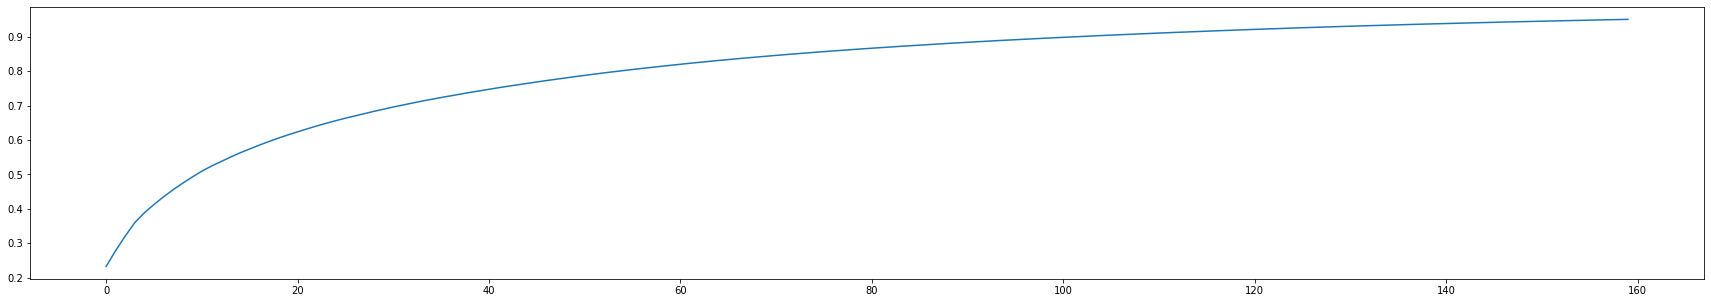

In [87]:
plt.figure(figsize=(30, 5))
plt.plot(pca.explained_variance_ratio_.cumsum())

In [88]:
pca.explained_variance_ratio_.cumsum()

array([0.23235699, 0.27888568, 0.32108146, 0.36019194, 0.38865406,
       0.41259664, 0.43482426, 0.45557659, 0.47442493, 0.49248823,
       0.50940735, 0.52414924, 0.53738673, 0.5503636 , 0.56281927,
       0.57411302, 0.58508419, 0.59556202, 0.60549186, 0.61488728,
       0.62368536, 0.63241505, 0.64077364, 0.64869206, 0.65625395,
       0.66340363, 0.67016264, 0.67684682, 0.68342308, 0.68982427,
       0.69591373, 0.70177245, 0.70745776, 0.71308361, 0.71835786,
       0.72348363, 0.72845481, 0.73341521, 0.73828654, 0.7429236 ,
       0.74746643, 0.75199728, 0.75634688, 0.76053745, 0.7647065 ,
       0.76875271, 0.77277046, 0.77669348, 0.78049072, 0.78424563,
       0.78789825, 0.7915259 , 0.79503519, 0.79842651, 0.80174152,
       0.80500246, 0.80817124, 0.81123592, 0.81427998, 0.81729248,
       0.82022417, 0.82308503, 0.82588598, 0.8286129 , 0.83127082,
       0.83387304, 0.83645155, 0.83893122, 0.84133959, 0.8436935 ,
       0.84600313, 0.84830434, 0.85054965, 0.85272869, 0.85487

In [89]:
pca_result_df = pd.DataFrame(pca_result, index=BERT_BY_IDX_DF.index)

In [91]:
pca_result_df.to_pickle('bert_by_idx_pca.pkl')

In [92]:
final_user_reps = pd.read_pickle('final_user_reps.pkl')
final_stream_reps = pd.read_pickle('final_stream_reps.pkl')

In [95]:
final_user_reps.rename(columns={a:f'u{a}' for a in range(72)}, inplace=True)

In [96]:
final_stream_reps.rename(columns={a:f's{a}' for a in range(72)}, inplace=True)

In [101]:
new_cols = pd.concat([final_user_reps.xs(('1000057940522534', 3397)), final_stream_reps.loc[3397]]).index.tolist()

In [102]:
test_context = pd.DataFrame(index=final_user_reps.index, columns=new_cols)

In [104]:
# (1000057940522534, 3397)
for asid, stream in tqdm(FINAL_USER_REPS.index):
  cc = pd.concat([final_user_reps.xs((asid, stream)), final_stream_reps.loc[stream]])
  test_context.loc[(asid, stream)] = cc

  0%|          | 0/1397141 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [110]:
stream2merge = final_user_reps.progress_apply(lambda x: final_stream_reps.loc[x.name[1]], axis=1)

  0%|          | 0/1397141 [00:00<?, ?it/s]

In [113]:
final_context = final_user_reps.merge(stream2merge, left_index=True, right_index=True).progress_apply(lambda x: x)

  0%|          | 0/181 [00:00<?, ?it/s]

In [118]:
final_context.to_pickle('final_context.pkl')

In [103]:
test_context.shape

(1397141, 181)

In [ ]:
test_context.to_pickle('test_context.pkl')

In [3]:
test_context = pd.read_pickle('test_context.pkl')


EOFError: Ran out of input

In [69]:
BERT_BY_IDX_DF = pd.read_pickle('bert_by_idx_df.pkl')
type(BERT_BY_IDX_DF)

pandas.core.frame.DataFrame

In [70]:
BERT_BY_IDX_DF.shape

(162189, 768)

In [135]:
CONTEXT_REPS = pd.read_pickle('final_context.pkl')
for x in CONTEXT_REPS.index:
  print(x)
  break
  

('1000057940522534', 3397)
